# Anomaly detection

In [ ]:
pip install opendatasets

In [ ]:
import opendatasets as od
import zipfile
import os
import numpy as np
import pandas as pd

# Specify the Kaggle dataset URL
dataset_url = 'https://www.kaggle.com/datasets/adityagaikwad9552/ucf-crime-splitted-i3d-features'

# Download the dataset (will download as a zip file by default)
od.download(dataset_url)

Dataset URL: https://www.kaggle.com/datasets/adityagaikwad9552/ucf-crime-splitted-i3d-features


100%|██████████| 2.48G/2.48G [00:28<00:00, 91.9MB/s]


In [ ]:
import os
import shutil
import zipfile
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
Dataset = '/content/ucf-crime-splitted-i3d-features'

def print_detailed_video_sequence_stats(base_dir):
    for split in ['train', 'val', 'test']:
        print(f"\n {split.upper()} SET:")
        split_dir = os.path.join(base_dir, split)

        total_videos = 0
        total_sequences = 0

        for label in ['normal', 'anomaly']:
            label_path = os.path.join(split_dir, label)
            label_video_count = 0
            label_seq_count = 0

            for video in os.listdir(label_path):
                video_path = os.path.join(label_path, video)
                if os.path.isdir(video_path):
                    label_video_count += 1
                    label_seq_count += len([
                        f for f in os.listdir(video_path) if f.endswith('.npz')
                    ])

            total_videos += label_video_count
            total_sequences += label_seq_count

            print(f"   {label.capitalize():<8}: {label_video_count:>4} videos, {label_seq_count:>5} sequences")

        print(f"   TOTAL     : {total_videos:>4} videos, {total_sequences:>5} sequences")


print_detailed_video_sequence_stats(Dataset)



 TRAIN SET:
   Normal  :  665 videos, 39286 sequences
   Anomaly :  665 videos, 34223 sequences
   TOTAL     : 1330 videos, 73509 sequences

 VAL SET:
   Normal  :  142 videos,  8382 sequences
   Anomaly :  143 videos,  7965 sequences
   TOTAL     :  285 videos, 16347 sequences

 TEST SET:
   Normal  :  143 videos,  9071 sequences
   Anomaly :  142 videos,  7632 sequences
   TOTAL     :  285 videos, 16703 sequences


In [ ]:
def load_split_sequences(base_dir):
    X, y = [], []
    for label in ['normal', 'anomaly']:
        label_path = os.path.join(base_dir, label)
        label_value = 0 if label == 'normal' else 1
        for video in tqdm(os.listdir(label_path), desc=f"Loading {label}"):
            video_path = os.path.join(label_path, video)
            for file in sorted(os.listdir(video_path)):
                if file.endswith('.npz'):
                    arr = np.load(os.path.join(video_path, file))['feature_array']
                    X.append(arr)
                    y.append(label_value)
    return np.array(X), np.array(y)

X_train, y_train = load_split_sequences(os.path.join(Dataset, 'train'))
X_val, y_val = load_split_sequences(os.path.join(Dataset, 'val'))
X_test, y_test = load_split_sequences(os.path.join(Dataset, 'test'))


Loading anomaly: 100%|██████████| 142/142 [00:04<00:00, 28.43it/s]


In [ ]:
X_train.shape

(73509, 7, 1, 1, 1024)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

def evaluate_set(split_name, model, X, y):
    y_prob = model.predict(X).flatten()
    y_pred = (y_prob >= 0.5).astype(int)

    acc = accuracy_score(y, y_pred)
    prec = precision_score(y, y_pred)
    rec = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    roc = roc_auc_score(y, y_prob)

    print(f"Accuracy      : {acc:.4f}")
    print(f"Precision     : {prec:.4f}")
    print(f"Recall        : {rec:.4f}")
    print(f"F1 Score      : {f1:.4f}")
    print(f"ROC AUC       : {roc:.4f}")
    print("Confusion Matrix:\n", confusion_matrix(y, y_pred))
    print("Classification Report:\n", classification_report(y, y_pred))


## models

### mean model

In [ ]:
def get_model_mean(input_shape=(7, 1, 1, 1024)):
    inputs = tf.keras.Input(shape=input_shape)
    x = layers.Reshape((7, 1024))(inputs)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(1, activation='sigmoid')(x)
    return tf.keras.Model(inputs, x)

model = get_model_mean()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
checkpoint = tf.keras.callbacks.ModelCheckpoint("mean.keras", save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32, callbacks=[checkpoint], verbose=1)



Epoch 1/10
2298/2298 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8053 - loss: 0.4130
Epoch 1: val_accuracy improved from -inf to 0.79409, saving model to mean.keras
2298/2298 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.8053 - loss: 0.4130 - val_accuracy: 0.7941 - val_loss: 0.5248
Epoch 2/10
2295/2298 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9245 - loss: 0.1965
Epoch 2: val_accuracy did not improve from 0.79409
2298/2298 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9245 - loss: 0.1965 - val_accuracy: 0.7923 - val_loss: 0.5524
Epoch 3/10
2297/2298 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9526 - loss: 0.1272
Epoch 3: val_accuracy improved from 0.79409 to 0.80314, saving model to mean.keras
2298/2298 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9526 - loss: 0.1272 - val_accuracy: 0.8031 - val_loss: 0.5624
Epoch 4/10
2298/2298 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9648 - loss: 0.0937
Epoch 4: val_accuracy did not improve from 0.80314
2298/2298 ━━━━━━━━━━━━━━━

In [ ]:
model = tf.keras.models.load_model("mean.keras")
evaluate_set("Validation", model, X_val, y_val)

511/511 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Accuracy      : 0.8142
Precision     : 0.8478
Recall        : 0.7539
F1 Score      : 0.7981
ROC AUC       : 0.8907
Confusion Matrix:
 [[7304 1078]
 [1960 6005]]
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.87      0.83      8382
           1       0.85      0.75      0.80      7965

    accuracy                           0.81     16347
   macro avg       0.82      0.81      0.81     16347
weighted avg       0.82      0.81      0.81     16347



### Max model

In [ ]:
def get_model_max(input_shape=(7, 1, 1, 1024)):
    inputs = tf.keras.Input(shape=input_shape)
    x = layers.Reshape((7, 1024))(inputs)
    x = layers.GlobalMaxPooling1D()(x)
    # x = layers.Dense(512, activation='relu')(x)
    # x = layers.Dropout(0.3)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(1, activation='sigmoid')(x)
    return tf.keras.Model(inputs, x)

model = get_model_max()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
checkpoint = tf.keras.callbacks.ModelCheckpoint("max.keras", save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=128, callbacks=[checkpoint], verbose=1)

Epoch 1/10
575/575 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7667 - loss: 0.4706
Epoch 1: val_accuracy improved from -inf to 0.76932, saving model to max.keras
575/575 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.7668 - loss: 0.4704 - val_accuracy: 0.7693 - val_loss: 0.5158
Epoch 2/10
567/575 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8888 - loss: 0.2729
Epoch 2: val_accuracy improved from 0.76932 to 0.79617, saving model to max.keras
575/575 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8889 - loss: 0.2728 - val_accuracy: 0.7962 - val_loss: 0.5067
Epoch 3/10
565/575 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9028 - loss: 0.2376
Epoch 3: val_accuracy improved from 0.79617 to 0.80229, saving model to max.keras
575/575 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9028 - loss: 0.2375 - val_accuracy: 0.8023 - val_loss: 0.5217
Epoch 4/10
566/575 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9137 - loss: 0.2080
Epoch 4: val_accuracy improved from 0.80229 to 0.80339, savin

In [ ]:
model = tf.keras.models.load_model("max.keras")
evaluate_set("Validation", model, X_val, y_val)

511/511 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Accuracy      : 0.8250
Precision     : 0.8557
Recall        : 0.7707
F1 Score      : 0.8110
ROC AUC       : 0.8831
Confusion Matrix:
 [[7347 1035]
 [1826 6139]]
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.88      0.84      8382
           1       0.86      0.77      0.81      7965

    accuracy                           0.82     16347
   macro avg       0.83      0.82      0.82     16347
weighted avg       0.83      0.82      0.82     16347



### Flatten

In [ ]:
def get_model_flatten(input_shape=(7, 1, 1, 1024)):
    inputs = tf.keras.Input(shape=input_shape)
    x = layers.Flatten()(inputs)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(1, activation='sigmoid')(x)
    return tf.keras.Model(inputs, x)

model = get_model_flatten()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
checkpoint = tf.keras.callbacks.ModelCheckpoint("flatten.keras", save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=128, callbacks=[checkpoint], verbose=1)



Epoch 1/10
575/575 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7720 - loss: 0.4747
Epoch 1: val_accuracy improved from -inf to 0.80975, saving model to flatten.keras
575/575 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.7721 - loss: 0.4746 - val_accuracy: 0.8098 - val_loss: 0.4632
Epoch 2/10
565/575 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8816 - loss: 0.2732
Epoch 2: val_accuracy did not improve from 0.80975
575/575 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.8817 - loss: 0.2730 - val_accuracy: 0.7946 - val_loss: 0.5158
Epoch 3/10
567/575 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8963 - loss: 0.2382
Epoch 3: val_accuracy did not improve from 0.80975
575/575 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8964 - loss: 0.2380 - val_accuracy: 0.7940 - val_loss: 0.5214
Epoch 4/10
574/575 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9009 - loss: 0.2219
Epoch 4: val_accuracy did not improve from 0.80975
575/575 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9009 - loss:

In [ ]:
model = tf.keras.models.load_model("flatten.keras")
evaluate_set("Validation", model, X_val, y_val)

511/511 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Accuracy      : 0.8163
Precision     : 0.8252
Recall        : 0.7903
F1 Score      : 0.8074
ROC AUC       : 0.8796
Confusion Matrix:
 [[7049 1333]
 [1670 6295]]
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.84      0.82      8382
           1       0.83      0.79      0.81      7965

    accuracy                           0.82     16347
   macro avg       0.82      0.82      0.82     16347
weighted avg       0.82      0.82      0.82     16347



### cnn model

In [ ]:
def get_model_cnn(input_shape=(7, 1, 1, 1024)):
    inputs = tf.keras.Input(shape=input_shape)
    x = layers.Reshape((7, 1024))(inputs)
    x = layers.Conv1D(128, 3, activation='relu', padding='same')(x)
    # x = layers.Dropout(0.5)(x)
    x = layers.Conv1D(128, 3, activation='relu', padding='same')(x)
    x = layers.GlobalMaxPooling1D()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    return tf.keras.Model(inputs, outputs)

model = get_model_cnn()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
checkpoint = tf.keras.callbacks.ModelCheckpoint("cnn.keras", save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5, batch_size=32, callbacks=[checkpoint], verbose=1)


Epoch 1/5
2298/2298 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7940 - loss: 0.4304
Epoch 1: val_accuracy improved from -inf to 0.79660, saving model to cnn.keras
2298/2298 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - accuracy: 0.7940 - loss: 0.4303 - val_accuracy: 0.7966 - val_loss: 0.5422
Epoch 2/5
2287/2298 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9372 - loss: 0.1688
Epoch 2: val_accuracy improved from 0.79660 to 0.80669, saving model to cnn.keras
2298/2298 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.9373 - loss: 0.1687 - val_accuracy: 0.8067 - val_loss: 0.6951
Epoch 3/5
2291/2298 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9591 - loss: 0.1133
Epoch 3: val_accuracy did not improve from 0.80669
2298/2298 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.9591 - loss: 0.1133 - val_accuracy: 0.7869 - val_loss: 0.7228
Epoch 4/5
2293/2298 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9704 - loss: 0.0837
Epoch 4: val_accuracy did not improve from 0.80669
2298/2298 ━━━━━━━━━━━━━━━━━━━

In [ ]:
model = tf.keras.models.load_model("cnn.keras")
evaluate_set("Validation", model, X_val, y_val)

511/511 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Accuracy      : 0.8116
Precision     : 0.8202
Recall        : 0.7857
F1 Score      : 0.8026
ROC AUC       : 0.8761
Confusion Matrix:
 [[7010 1372]
 [1707 6258]]
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.84      0.82      8382
           1       0.82      0.79      0.80      7965

    accuracy                           0.81     16347
   macro avg       0.81      0.81      0.81     16347
weighted avg       0.81      0.81      0.81     16347



### lstm model

In [ ]:
def get_model_lstm(input_shape=(7, 1, 1, 1024)):
    inputs = tf.keras.Input(shape=input_shape)
    x = layers.Reshape((7, 1024))(inputs)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=False))(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    return tf.keras.Model(inputs, outputs)

model = get_model_lstm()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
checkpoint = tf.keras.callbacks.ModelCheckpoint("lstm.keras", save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=64, callbacks=[checkpoint], verbose=1)


Epoch 1/10
1147/1149 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8278 - loss: 0.3691
Epoch 1: val_accuracy improved from -inf to 0.77806, saving model to lstm.keras
1149/1149 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.8280 - loss: 0.3687 - val_accuracy: 0.7781 - val_loss: 0.6451
Epoch 2/10
1146/1149 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9725 - loss: 0.0773
Epoch 2: val_accuracy improved from 0.77806 to 0.78736, saving model to lstm.keras
1149/1149 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step - accuracy: 0.9725 - loss: 0.0772 - val_accuracy: 0.7874 - val_loss: 1.0739
Epoch 3/10
1145/1149 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9844 - loss: 0.0443
Epoch 3: val_accuracy did not improve from 0.78736
1149/1149 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.9844 - loss: 0.0443 - val_accuracy: 0.7795 - val_loss: 1.2257
Epoch 4/10
1147/1149 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9896 - loss: 0.0304
Epoch 4: val_accuracy improved from 0.78736 to 0.79941, saving mode

In [ ]:
model = tf.keras.models.load_model("lstm.keras")
evaluate_set("Validation", model, X_val, y_val)

511/511 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
Accuracy      : 0.8121
Precision     : 0.8315
Recall        : 0.7705
F1 Score      : 0.7998
ROC AUC       : 0.8862
Confusion Matrix:
 [[7138 1244]
 [1828 6137]]
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.85      0.82      8382
           1       0.83      0.77      0.80      7965

    accuracy                           0.81     16347
   macro avg       0.81      0.81      0.81     16347
weighted avg       0.81      0.81      0.81     16347



### gru model

In [ ]:

def get_model_gru(input_shape=(7, 1, 1, 1024)):
    inputs = tf.keras.Input(shape=input_shape)
    x = layers.Reshape((7, 1024))(inputs)
    x = layers.Bidirectional(layers.GRU(64, return_sequences=True))(x)
    x = layers.Bidirectional(layers.GRU(64, return_sequences=False))(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    return tf.keras.Model(inputs, outputs)
model = get_model_gru()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
checkpoint = tf.keras.callbacks.ModelCheckpoint("gru.keras", save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=64, callbacks=[checkpoint], verbose=1)

Epoch 1/10
1149/1149 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.8042 - loss: 0.4131
Epoch 1: val_accuracy improved from -inf to 0.78895, saving model to gru.keras
1149/1149 ━━━━━━━━━━━━━━━━━━━━ 97s 75ms/step - accuracy: 0.8043 - loss: 0.4130 - val_accuracy: 0.7890 - val_loss: 0.6502
Epoch 2/10
1148/1149 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9630 - loss: 0.1042
Epoch 2: val_accuracy improved from 0.78895 to 0.80094, saving model to gru.keras
1149/1149 ━━━━━━━━━━━━━━━━━━━━ 139s 73ms/step - accuracy: 0.9630 - loss: 0.1041 - val_accuracy: 0.8009 - val_loss: 0.9402
Epoch 3/10
1149/1149 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.9825 - loss: 0.0508
Epoch 3: val_accuracy did not improve from 0.80094
1149/1149 ━━━━━━━━━━━━━━━━━━━━ 166s 93ms/step - accuracy: 0.9825 - loss: 0.0508 - val_accuracy: 0.7908 - val_loss: 1.1785
Epoch 4/10
1149/1149 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.9894 - loss: 0.0301
Epoch 4: val_accuracy did not improve from 0.80094
1149/1149 ━━━━━━

In [ ]:
model = tf.keras.models.load_model("gru.keras")
evaluate_set("Validation", model, X_val, y_val)


511/511 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Accuracy      : 0.8061
Precision     : 0.8385
Recall        : 0.7458
F1 Score      : 0.7894
ROC AUC       : 0.8830
Confusion Matrix:
 [[7238 1144]
 [2025 5940]]
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.86      0.82      8382
           1       0.84      0.75      0.79      7965

    accuracy                           0.81     16347
   macro avg       0.81      0.80      0.80     16347
weighted avg       0.81      0.81      0.81     16347



## Evaluate Ensemble Model on Validation Set (Sequence-Level)
We ensemble all models by averaging their sequence-level prediction probabilities and evaluate the result using standard metrics.


In [ ]:
from tensorflow.keras.models import load_model
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report
)
import numpy as np
from tqdm import tqdm

# Function to load model and get predictions
def load_model_preds(model_path, X):
    model = load_model(model_path)
    preds = model.predict(X, verbose=0)
    return preds.squeeze()

# Evaluation metrics function
def evaluate_preds(y_true, y_probs, threshold=0.5):
    y_pred = (y_probs >= threshold).astype(int)
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred),
        "recall": recall_score(y_true, y_pred),
        "f1": f1_score(y_true, y_pred),
        "roc_auc": roc_auc_score(y_true, y_probs),
        "confusion_matrix": confusion_matrix(y_true, y_pred),
        "classification_report": classification_report(y_true, y_pred)
    }

# Ensemble model prediction and evaluation
def ensemble_all_models(X, y, model_paths):
    all_preds = []
    for model_name, model_path in tqdm(model_paths.items(), desc="Loading Models"):
        preds = load_model_preds(model_path, X)
        all_preds.append(preds)

    avg_preds = np.mean(all_preds, axis=0)
    metrics = evaluate_preds(y, avg_preds)

    print("\n✅ Ensemble of All Models (Sequence-Level):")
    for k in ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']:
        print(f"{k.capitalize():<15}: {metrics[k]:.4f}")
    print("\n📊 Confusion Matrix:")
    print(metrics['confusion_matrix'])
    print("\n📋 Classification Report:")
    print(metrics['classification_report'])

    return metrics

# Model paths
model_paths = {
    "mean": "mean.keras",
    "max": "max.keras",
    "flatten": "flatten.keras",
    "cnn": "cnn.keras",
    "lstm": "lstm.keras",
    "gru": "gru.keras"
}

ensemble_val_metrics = ensemble_all_models(X_val, y_val, model_paths)


Loading Models: 100%|██████████| 6/6 [00:31<00:00,  5.31s/it]


✅ Ensemble of All Models (Sequence-Level):
Accuracy       : 0.8301
Precision      : 0.8544
Recall         : 0.7849
F1             : 0.8182
Roc_auc        : 0.8994

📊 Confusion Matrix:
[[7317 1065]
 [1713 6252]]

📋 Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.87      0.84      8382
           1       0.85      0.78      0.82      7965

    accuracy                           0.83     16347
   macro avg       0.83      0.83      0.83     16347
weighted avg       0.83      0.83      0.83     16347



## Visualize All Models' Metrics on Validation Set
This plot highlights summary of the relative performance of each model across different metrics,


Evaluating Models: 100%|██████████| 6/6 [00:33<00:00,  5.51s/it]
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


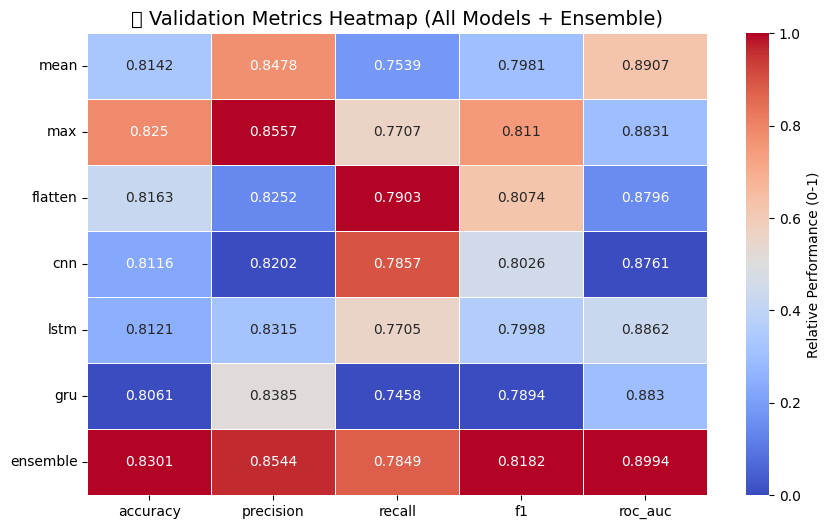

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Function to evaluate individual models
def evaluate_model(X, y_true, model_path, threshold=0.5):
    y_probs = load_model_preds(model_path, X)
    y_pred = (y_probs >= threshold).astype(int)

    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred),
        "recall": recall_score(y_true, y_pred),
        "f1": f1_score(y_true, y_pred),
        "roc_auc": roc_auc_score(y_true, y_probs),
    }

# Collect metrics for all models
def collect_all_metrics(X, y, model_paths):
    metrics = {}
    for name, path in tqdm(model_paths.items(), desc="Evaluating Models"):
        metrics[name] = evaluate_model(X, y, path)
    metrics["ensemble"] = {k: ensemble_val_metrics[k] for k in ["accuracy", "precision", "recall", "f1", "roc_auc"]}
    return pd.DataFrame(metrics).T

# Create and normalize DataFrame
metrics_df = collect_all_metrics(X_val, y_val, model_paths)

normalized_df = metrics_df.copy()
for col in normalized_df.columns:
    col_min = normalized_df[col].min()
    col_max = normalized_df[col].max()
    normalized_df[col] = (normalized_df[col] - col_min) / (col_max - col_min)

# Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(normalized_df, annot=metrics_df.round(4), fmt="", cmap="coolwarm", linewidths=0.5, cbar_kws={"label": "Relative Performance (0-1)"})
plt.title("📊 Validation Metrics Heatmap (All Models + Ensemble)", fontsize=14)
plt.yticks(rotation=0)
plt.show()


## Evaluate Video-Level Ensemble on Validation Set
We evaluate at the video level using a below rule

### Video Evaluation Rule

A video is labeled **anomalous** if **≥ video_anomaly_proportion_threshold%** of its sequences have an anomaly probability **≥ sequence_anomaly_confidence_threshold**.  
Otherwise, it is labeled **normal**.

**Where:**

1. **sequence_anomaly_confidence_threshold** — the minimum probability for a sequence to be considered anomalous.

2. **video_anomaly_proportion_threshold** — the minimum percentage of sequences in the video that must meet the confidence threshold for the whole video to be classified as anomalous.



In [ ]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score
)

# ==== CONFIG ====
LABEL_MAP = {'normal': 0, 'anomaly': 1}
model_paths = {
    "mean": "mean.keras",
    "max": "max.keras",
    "flatten": "flatten.keras",
    "cnn": "cnn.keras",
    "lstm": "lstm.keras",
    "gru": "gru.keras"
}

VAL_SPLIT_DIR = "/content/ucf-crime-splitted-i3d-features/val"

# ==== Load Models ====
print("🔄 Loading models...")
models = {name: load_model(path) for name, path in model_paths.items()}
print("✅ Models ready!\n")

# ==== Predict Helper ====
@tf.function(reduce_retracing=True)
def predict_model(model, inputs):
    return model(inputs, training=False)

# ==== Load All Videos ONCE ====
print("📂 Loading validation videos...")

video_data = []  # [(label, [sequences])]
for label in ['normal', 'anomaly']:
    label_dir = os.path.join(VAL_SPLIT_DIR, label)
    if not os.path.isdir(label_dir):
        continue

    for video in tqdm(os.listdir(label_dir), desc=f"Loading {label}", unit="video"):
        path = os.path.join(label_dir, video)
        sequences = []
        for file in sorted(os.listdir(path)):
            if file.endswith('.npz'):
                arr = np.load(os.path.join(path, file))['feature_array']
                sequences.append(arr)
        video_data.append({
            "label": LABEL_MAP[label],
            "sequences": np.array(sequences)
        })

print(f"✅ Total videos loaded: {len(video_data)}\n")

# ==== Video prediction ====
def predict_video_label_and_score(sequences, conf_thresh, threshold_percent):
    if len(sequences) == 0:
        return 0, 0.5
    all_preds = [predict_model(model, sequences).numpy().squeeze() for model in models.values()]
    avg_preds = np.mean(np.stack(all_preds), axis=0)
    high_conf = np.sum(avg_preds >= conf_thresh)
    threshold_count = max(1, int(np.ceil(len(sequences) * threshold_percent)))
    pred = int(high_conf >= threshold_count)
    return pred, np.mean(avg_preds)

# ==== Grid Search ====
conf_range = np.arange(0.87, 0.91 + 0.001, 0.01)
percent_range = np.arange(0.040, 0.070 + 0.0001, 0.001)

results = []
total_steps = len(conf_range) * len(percent_range)

print(f"🔍 Grid Search: {total_steps} combinations...\n")

with tqdm(total=total_steps, desc="Grid Search", unit="comb") as pbar:
    for conf_thresh in conf_range:
        for percent_thresh in percent_range:
            y_true, y_pred, y_scores = [], [], []
            for vid in video_data:
                pred, score = predict_video_label_and_score(
                    vid['sequences'],
                    conf_thresh,
                    percent_thresh
                )
                y_true.append(vid['label'])
                y_pred.append(pred)
                y_scores.append(score)

            try:
                roc_auc = roc_auc_score(y_true, y_scores)
            except:
                roc_auc = np.nan

            row = {
                "sequence_anomaly_confidence_threshold": round(conf_thresh, 3),
                "video_anomaly_proportion_threshold": round(percent_thresh, 3),
                "precision": precision_score(y_true, y_pred, zero_division=0),
                "recall": recall_score(y_true, y_pred, zero_division=0),
                "f1": f1_score(y_true, y_pred, zero_division=0),
                "roc_auc": roc_auc,
                "accuracy": accuracy_score(y_true, y_pred)
            }
            results.append(row)
            pbar.set_postfix({
                "conf": f"{conf_thresh:.3f}",
                "percent": f"{percent_thresh:.3f}",
                "f1": f"{row['f1']:.4f}"
            })
            pbar.update(1)

# ==== create dataframe of results ====
df = pd.DataFrame(results)
print("\n✅ Grid Search Done!")

🔄 Loading models...
✅ Models ready!

📂 Loading validation videos...


Loading anomaly: 100%|██████████| 143/143 [00:08<00:00, 16.49video/s]


✅ Total videos loaded: 285

🔍 Grid Search: 155 combinations...



Grid Search: 100%|██████████| 155/155 [30:15<00:00, 11.71s/comb, conf=0.910, percent=0.070, f1=0.8664]


✅ Grid Search Done!


In [ ]:
df.sort_values(by="f1", ascending=False).head()

,sequence_anomaly_confidence_threshold,video_anomaly_proportion_threshold,precision,recall,f1,roc_auc,accuracy
112,0.90,0.059,0.897059,0.853147,0.874552,0.937408,0.877193
114,0.90,0.061,0.897059,0.853147,0.874552,0.937408,0.877193
83,0.89,0.061,0.897059,0.853147,0.874552,0.937408,0.877193
82,0.89,0.060,0.897059,0.853147,0.874552,0.937408,0.877193
84,0.89,0.062,0.897059,0.853147,0.874552,0.937408,0.877193


In [ ]:
df.sort_values(by="recall", ascending=False).head()

,sequence_anomaly_confidence_threshold,video_anomaly_proportion_threshold,precision,recall,f1,roc_auc,accuracy
0,0.87,0.040,0.848276,0.86014,0.854167,0.937408,0.852632
1,0.87,0.041,0.848276,0.86014,0.854167,0.937408,0.852632
2,0.87,0.042,0.848276,0.86014,0.854167,0.937408,0.852632
3,0.87,0.043,0.848276,0.86014,0.854167,0.937408,0.852632
4,0.87,0.044,0.848276,0.86014,0.854167,0.937408,0.852632


In [ ]:
df.sort_values(by="precision", ascending=False).head()

,sequence_anomaly_confidence_threshold,video_anomaly_proportion_threshold,precision,recall,f1,roc_auc,accuracy
112,0.90,0.059,0.897059,0.853147,0.874552,0.937408,0.877193
114,0.90,0.061,0.897059,0.853147,0.874552,0.937408,0.877193
83,0.89,0.061,0.897059,0.853147,0.874552,0.937408,0.877193
82,0.89,0.060,0.897059,0.853147,0.874552,0.937408,0.877193
84,0.89,0.062,0.897059,0.853147,0.874552,0.937408,0.877193


The choice of thresholds depends on the desired balance between recall and precision:

1. To prioritize high recall — ensuring that most anomalies are detected, even at the cost of some additional false positives — use:

    sequence_anomaly_confidence_threshold = 0.87
    video_anomaly_proportion_threshold = 0.04
*************************************************************

2. If false alarms are costly and a more balanced trade-off is preferred — minimizing unnecessary alerts while still detecting anomalies effectively — use the configuration that maximizes precision and F1 score - use:

    sequence_anomaly_confidence_threshold = 0.90
    video_anomaly_proportion_threshold = 0.059

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, classification_report
)
from tqdm import tqdm


# Example config
model_paths = {
    "mean": "mean.keras",
    "max": "max.keras",
    "flatten": "flatten.keras",
    "cnn": "cnn.keras",
    "lstm": "lstm.keras",
    "gru": "gru.keras"
}

import os
import numpy as np
from tqdm import tqdm

def load_video_split(split_dir):
    """
    Loads all videos in split_dir (should have normal/ & anomaly/)
    Returns list of dicts: [{ 'label': 0/1, 'sequences': np.array(...) }, ...]
    """
    video_data = []
    LABEL_MAP = {'normal': 0, 'anomaly': 1}

    for label in ['normal', 'anomaly']:
        label_dir = os.path.join(split_dir, label)
        if not os.path.isdir(label_dir):
            continue
        for video_name in tqdm(os.listdir(label_dir), desc=f"Loading {label} videos", unit="video"):
            video_path = os.path.join(label_dir, video_name)
            if not os.path.isdir(video_path):
                continue
            sequences = []
            for file in sorted(os.listdir(video_path)):
                if file.endswith('.npz'):
                    arr = np.load(os.path.join(video_path, file))['feature_array']
                    sequences.append(arr)
            if sequences:
                video_data.append({
                    'label': LABEL_MAP[label],
                    'sequences': np.array(sequences)
                })
    return video_data



# === Core prediction ===
@tf.function(reduce_retracing=True)
def predict_model(model, inputs):
    return model(inputs, training=False)

# === Per-video prediction ===
def predict_video_label_and_score(sequences, models, conf_thresh, threshold_percent):
    if len(sequences) == 0:
        return 0, 0.5
    all_preds = [predict_model(model, sequences).numpy().squeeze() for model in models.values()]
    avg_preds = np.mean(np.stack(all_preds), axis=0)
    high_conf = np.sum(avg_preds >= conf_thresh)
    threshold_count = max(1, int(np.ceil(len(sequences) * threshold_percent)))
    pred = int(high_conf >= threshold_count)
    return pred, np.mean(avg_preds)

# ✅ All-in-one function: loads models, predicts, prints
def evaluate_split_with_ensemble(
    video_data,
    model_paths,
    sequence_anomaly_confidence_threshold=0.89,
    video_anomaly_proportion_threshold=0.059,
    desc="Evaluating"
):
    print("🔄 Loading models...")
    models = {name: load_model(path) for name, path in model_paths.items()}
    print(f"✅ {len(models)} models loaded.\n")

    y_true, y_pred, y_scores = [], [], []

    for vid in tqdm(video_data, desc=desc, unit="video"):
        pred, score = predict_video_label_and_score(
            vid['sequences'], models, sequence_anomaly_confidence_threshold, video_anomaly_proportion_threshold
        )
        y_true.append(vid['label'])
        y_pred.append(pred)
        y_scores.append(score)

    try:
        roc_auc = roc_auc_score(y_true, y_scores)
    except:
        roc_auc = np.nan

    metrics = {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred, zero_division=0),
        "roc_auc": roc_auc,
        "confusion_matrix": confusion_matrix(y_true, y_pred),
        "classification_report": classification_report(y_true, y_pred)
    }

    print("\n✅ Evaluation Results")
    print(f"→ Accuracy : {metrics['accuracy']:.4f}")
    print(f"→ Precision: {metrics['precision']:.4f}")
    print(f"→ Recall   : {metrics['recall']:.4f}")
    print(f"→ F1 Score : {metrics['f1']:.4f}")
    print(f"→ ROC AUC  : {metrics['roc_auc']:.4f}")
    print(f"\n📊 Confusion Matrix:\n{metrics['confusion_matrix']}")
    print(f"\n📋 Classification Report:\n{metrics['classification_report']}")

    return metrics


In [ ]:
# Load val data:
test_video_data = load_video_split('/content/ucf-crime-splitted-i3d-features/val')

# Then run the eval:
results = evaluate_split_with_ensemble(
    video_data=test_video_data,
    model_paths=model_paths,
    sequence_anomaly_confidence_threshold=0.90,
    video_anomaly_proportion_threshold=0.059
)


Loading anomaly videos: 100%|██████████| 143/143 [00:04<00:00, 30.70video/s]


🔄 Loading models...
✅ 6 models loaded.



Evaluating: 100%|██████████| 285/285 [00:14<00:00, 19.65video/s]


✅ Evaluation Results
→ Accuracy : 0.8772
→ Precision: 0.8971
→ Recall   : 0.8531
→ F1 Score : 0.8746
→ ROC AUC  : 0.9374

📊 Confusion Matrix:
[[128  14]
 [ 21 122]]

📋 Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.90      0.88       142
           1       0.90      0.85      0.87       143

    accuracy                           0.88       285
   macro avg       0.88      0.88      0.88       285
weighted avg       0.88      0.88      0.88       285



## Final Evaluation on Test Set (Video-Level)
We now evaluate on the test set using the best-performing threshold from the validation set


In [ ]:
# Load test data:
test_video_data = load_video_split('/content/ucf-crime-splitted-i3d-features/test')

# Then run the eval:
results = evaluate_split_with_ensemble(
    video_data=test_video_data,
    model_paths=model_paths,
    sequence_anomaly_confidence_threshold=0.90,
    video_anomaly_proportion_threshold=0.059
)


Loading anomaly videos: 100%|██████████| 142/142 [00:04<00:00, 34.05video/s]


🔄 Loading models...
✅ 6 models loaded.



Evaluating: 100%|██████████| 285/285 [00:17<00:00, 16.45video/s]


✅ Evaluation Results
→ Accuracy : 0.8842
→ Precision: 0.8978
→ Recall   : 0.8662
→ F1 Score : 0.8817
→ ROC AUC  : 0.9339

📊 Confusion Matrix:
[[129  14]
 [ 19 123]]

📋 Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.90      0.89       143
           1       0.90      0.87      0.88       142

    accuracy                           0.88       285
   macro avg       0.88      0.88      0.88       285
weighted avg       0.88      0.88      0.88       285

